### Bank Customer Churn

###### Objectives: 

Given a Bank customer, Can we build a classifier which can determine
whether they will leave or not?

In [1]:
# Importing the necessary modules
import pandas as pd
import numpy as np
import os 
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
os.chdir('E:\\Datasets')
os.listdir()

['airbnb-listings_netherlands.csv',
 'Churn_Modelling.csv',
 'creditcard.csv',
 'F1',
 'housing',
 'model.pkl',
 'PythonDA',
 'WideWorldImporters-Full.bak']

In [2]:
path = os.path.join(os.getcwd(),os.listdir()[1])
path

'E:\\Datasets\\Churn_Modelling.csv'

In [3]:
data = pd.read_csv(path,header=0) # loading the comma separated file. 

In [4]:
data.info() # checking the data type, total entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
data.head() # displaying the first 5 records to inspect the data. 

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


We can remove row number, customerid and surname from the observation as it won't help us in getting insights about the data further. 

In [6]:
data.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

In [7]:
data.isnull().any()

CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

The data appears to be clean with no null values we need to take care of. 
Before we examine the numerical values, lets get information on the categorical variables. 
Geography and the Gender

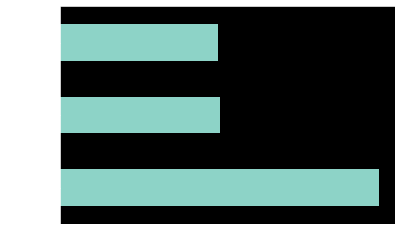

In [8]:
data['Geography'].value_counts().plot.barh() ; plt.show()

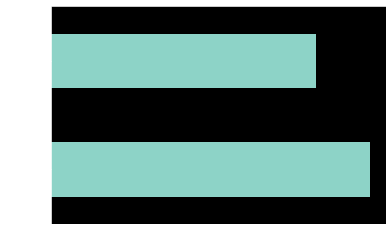

In [9]:
data['Gender'].value_counts().plot.barh() ; plt.show()

Let's see which country has the higest,lowest and average values with respect to credit score and Age

In [10]:
data.groupby(['Geography'])[['CreditScore','Age']].agg(['count'])

,CreditScore,Age
,count,count
Geography,,
France,5014,5014
Germany,2509,2509
Spain,2477,2477


It seems all the countries have the same min and max values with slight differences in their respective mean.

Lets plot a histogram to find the distribution of the data for the continous variables. 

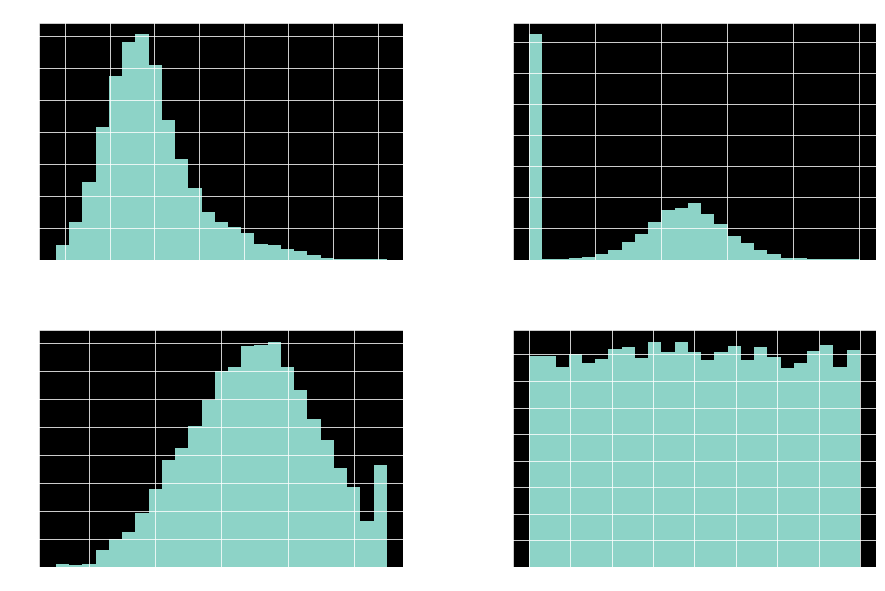

In [11]:
continous = ['Age','Balance','CreditScore','EstimatedSalary']
data[continous].hist(bins=25,figsize=(15,10))
plt.show()

    1.Age is close to a normal distribution with data skewed to the right.

    2.Balance: Expect for customers whose balance is 0, data is normally distributed. 

    3.Credict score is mostly left skewed with most of them in the range of 620 to 700 credits and close to 400 customers have highest credit score. 

    4.Estimated salary is pretty much balanced and close to uniform distribution. 


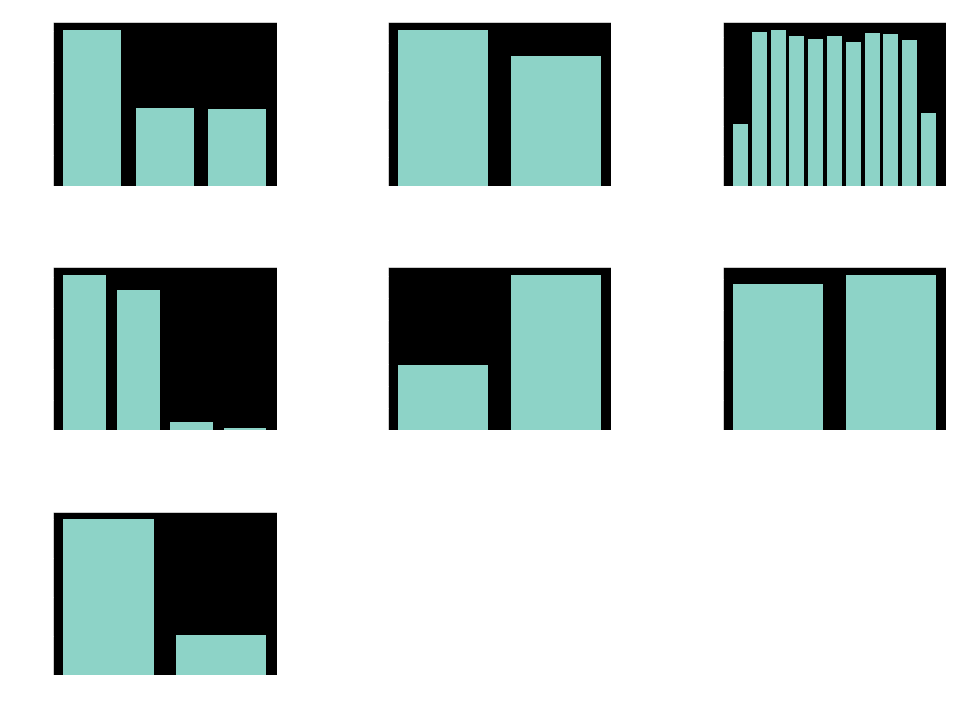

In [12]:
discrete = ['Geography','Gender', 'Tenure', 'NumOfProducts', 'HasCrCard','IsActiveMember', 'Exited']
plt.figure(figsize=(16,30))
for i,col in enumerate(data[discrete].columns):
    x = data[col].value_counts().index.values
    y = data[col].value_counts()
    plt.subplot(7,3,i+1)
    plt.bar(x,y,align='center')
    plt.title(col)
    plt.subplots_adjust(wspace=0.5,hspace=.5)
    plt.xlabel(f"Categories for {col}")
    plt.ylabel("value counts")

Clearly the response value is not balanced and we might have to balance it so that our model is not biased towards customer who have not exited.

Let's check the correlation between each featues

In [13]:
correlation = data.corr()

In [14]:
round(correlation.where((correlation > 0.1) | (correlation < -0.1)),2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,0.29
Tenure,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Balance,NaN,NaN,NaN,1.00,-0.3,NaN,NaN,NaN,0.12
NumOfProducts,NaN,NaN,NaN,-0.30,1.0,NaN,NaN,NaN,NaN
HasCrCard,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
IsActiveMember,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,-0.16
EstimatedSalary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Exited,NaN,0.29,NaN,0.12,NaN,NaN,-0.16,NaN,1.00


We don't see any strong correlation between the features. Let's build a scatter matrix between the continous variables.

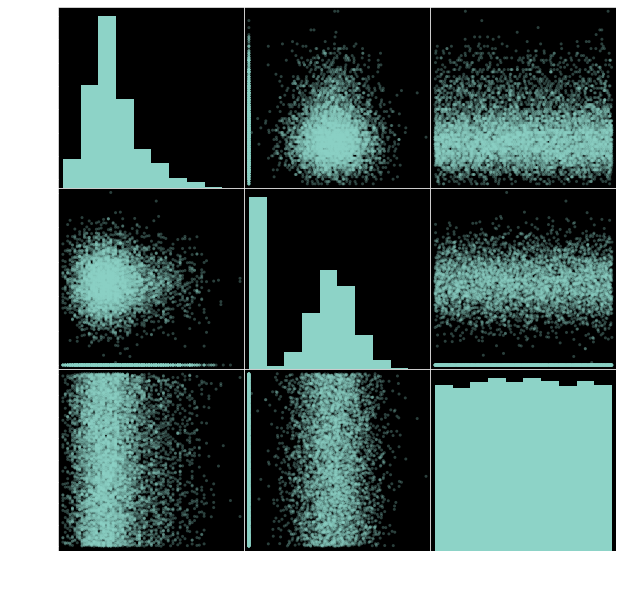

In [15]:
from pandas.plotting import scatter_matrix
columns = ['Age','Balance','EstimatedSalary']
scatter_matrix(data[columns],figsize=(10,10),alpha=0.3)
plt.show()

the estimated salary and Balance are uniformly distributed around 1M and 1.5M 

##### Data Preprocessing
We need to take care of the categorical variables. Let's encode the column Gender to 1 and 0 as there is only 2 values 

In [16]:
data['Gender'] = data['Gender'].map({'Male':1,'Female':0})
data['Gender'].value_counts()

1    5457
0    4543
Name: Gender, dtype: int64

In [17]:
# creating a separate data frame to keep a copy of the data from Original data
numerical = data.select_dtypes(include=np.number)
categorical = data.select_dtypes(include=np.object)

In [18]:
categorical_dummies = pd.get_dummies(categorical).astype('uint8')
categorical_dummies.head()

,Geography_France,Geography_Germany,Geography_Spain
0,1,0,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1


Let's drop the response variable from our data set as its the one we need to predict

In [19]:
response_variable = numerical['Exited'].copy().astype('uint8').values
numerical = numerical.drop('Exited',axis=1)

Let's concat the categorical dummies and split between train and test 

In [20]:
numerical = pd.concat([numerical,categorical_dummies],axis=1)
numerical.head(2)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1


Now that we have converted the data to numerical values we would need to split the data into train test sets

In [21]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(numerical,response_variable,test_size=0.2,
                                                 random_state=42)

We need to scale the data for the algorithm to converge faster and also the classifier we are going is sensitive to scaling.

In [22]:
from sklearn.preprocessing import StandardScaler
std_sclr = StandardScaler()
x_train = std_sclr.fit_transform(x_train)
x_test = std_sclr.transform(x_test)

Lets train the model and predict using SDGClassifier

In [23]:
from sklearn.linear_model import SGDClassifier

In [24]:
sgd_clsr = SGDClassifier(random_state=42,max_iter=1000)
sgd_clsr.fit(x_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
y_pred = sgd_clsr.predict(x_test)

In [26]:
# accuracy 
sum(y_test == y_pred) / len(y_test)

0.803

Our model gives 80% accuracy. 

Now lets import the sklearn cross validation library and do cross validation to see if we can get different accuracy with different train and validation set

In [27]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clsr,x_train,y_train,cv=5,scoring='accuracy')

array([0.80387258, 0.784375  , 0.779375  , 0.776875  , 0.81238274])

On an average we are still getting the accuracy closer to 80%. 
Lets try to perfrom stratified sampling with cross validation.

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=5,random_state=42)

In [29]:
for train_index,test_index in skfolds.split(x_train,y_train):
    clone_clf = clone(sgd_clsr)
    x_train_folds,y_train_folds = x_train[train_index],y_train[train_index]
    x_test_fold,y_test_fold  = x_train[test_index],y_train[test_index]
    
    clone_clf.fit(x_train_folds,y_train_folds)
    y_pred_fold = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred_fold == y_test_fold) / len(y_test_fold) 
    print(n_correct)

0.8038725796377264
0.784375
0.779375
0.776875
0.8123827392120075


Since the response variable data is not balanced the model provides an accuracy towards a naive prediction towards customers who will not exit. 

Lets test the model by creating a dumb classifier

In [30]:
from sklearn.base import BaseEstimator

class NotExited(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [31]:
notexit = NotExited()
cross_val_score(notexit,x_train_folds,y_train_folds,cv=5,scoring='accuracy')

array([0.80796253, 0.7765625 , 0.7796875 , 0.81875   , 0.7890625 ])

Our dumb classifier outputs 80% accuracy which is pretty much close to the SDGClassifier. Hence we cannot rely on the accuracy score and we also would need to balance the class in order to get  better prediction.

Lets balance the data by oversampling the minority class

In [32]:
from imblearn.over_sampling import SMOTE
balance = SMOTE(random_state=42)

x_train_over,y_train_over = balance.fit_sample(x_train_folds,y_train_folds)
print(x_train_over.shape,y_train_over.shape)

(10170, 12) (10170,)


In [33]:
print(f"customer NotExited value {sum(y_train_over==0)}")
print(f"customer Exited value {sum(y_train_over==1)}")

customer NotExited value 5085
customer Exited value 5085


Now that our data is up sampled we can now apply the SDG to get the score. 

In [34]:
sgd_clsr.fit(x_train_over,y_train_over)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
y_pred = sgd_clsr.predict(x_test_fold)

In [36]:
sum(y_test_fold == y_pred) / len(y_test_fold)

0.7073170731707317

Looks like after oversampling we get an accuracy of 72%, Let's try to see what we get for recall and precision

In [37]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clsr,x_train_over,y_train_over,cv=5)
np.unique(y_train_pred,return_counts=True)

(array([0, 1], dtype=uint8), array([4927, 5243], dtype=int64))

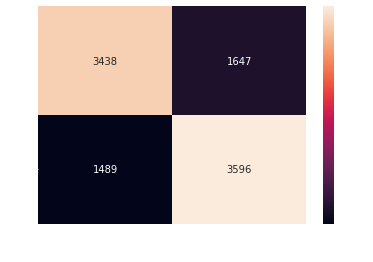

In [38]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_train_over,y_train_pred)

# using seaborn plotting the confusion matrix. 
sns.heatmap(cnf_matrix, annot=True,fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

It seems we might have to increase the recall to ensure we reduce the number of false negatives, where we would need to let certain few prediction as false positives. There is a trade off. 

In [39]:
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score

In [40]:
precision_score(y_train_over,y_train_pred)

0.685866870112531

In [41]:
recall_score(y_train_over,y_train_pred)

0.7071779744346116

In [42]:
f1_score(y_train_over,y_train_pred)

0.6963594113090628

In [43]:
y_scores = cross_val_predict(sgd_clsr,x_train_over,y_train_over,cv=3,method='decision_function')

In [44]:
roc_auc_score(y_train_over,y_scores)

0.754735243244393

#### Hyperparameter search
Let's fine tune the model to see if we can tune the hyperparamters using GridSearch

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
sgd_clsr.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [47]:
param_grid = {'alpha':10.0**-np.arange(1,7),
              'class_weight':['balanced',None],
              'penalty':[None,'l1','l2','elasticnet'],
              'n_iter_no_change':np.arange(5,10)}


scoring = ['f1','accuracy','precision','recall','roc_auc']


In [48]:
grid_search = GridSearchCV(sgd_clsr,param_grid,cv=5,n_jobs=-1,
                           scoring=scoring,refit='f1',
                          return_train_score=True)

In [49]:
%time grid_search.fit(x_train_over,y_train_over)

Wall time: 19.3 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation...0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                         'class_weight': ['balanced', None],
                         'n_iter_no_change': array([5, 6, 7, 8, 9]),
  

In [50]:
final_estimator = grid_search.best_estimator_
final_estimator

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=7, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=42, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
grid_search.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=7, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=42, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)

In [52]:
final_estimator.fit(x_train_over,y_train_over)
final_prediction = final_estimator.predict(x_test)
sum(y_test == final_prediction) / len(y_test)

0.7235

#### Conclusion

1) With this Model we are getting a lower accuracy, we can try out different ensemble models which could perform well and give better prediction. However, we may not get better accuracy as the model might not generalize well due to synthetic data created. <br>
2) We could try RandomizedSearchCV and search the hyperparameter space for the best estimator. <br>
3) Refactor code and make resuable functions. <br>

<br>
Even if we get the highest feasible accuracy there will be a trade off between true positive rate (recall) and false positive rate. <br>
<br>
Example. Lets say if onboarding new customers is more costlier than retaining existing customers. Then we want to capture all the True positives and have a higher recall rate, so that bank can decide to give certain discounts to retain the customers. 


In [54]:
from sklearn.ensemble import RandomForestClassifier
rforest_clsr = RandomForestClassifier(random_state=42,n_estimators=10)
rforest_clsr.fit(x_train_over,y_train_over)
y_pred_forest = rforest_clsr.predict(x_test)
sum(y_test == y_pred_forest) / len(y_test)

0.836

In [62]:
cross_val_score(rforest_clsr,x_train_over,y_train_over,cv=5,scoring='f1')

array([0.81366765, 0.87807276, 0.906588  , 0.90707965, 0.89282203])

In [110]:
rforest_clsr.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>

In [97]:
param_grid = {'n_estimators':np.arange(10,20),
#               'max_depth':np.arange(2,10),
              'max_features':np.arange(2,13),}


scoring = ['f1','accuracy','precision','recall','roc_auc']

grid_search = GridSearchCV(rforest_clsr,param_grid,cv=5,n_jobs=-1,
                           scoring=scoring,refit='f1',
                          return_train_score=True)

In [98]:
%time grid_search.fit(x_train_over,y_train_over)

Wall time: 24.7 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_fe

In [99]:
grid_search.best_params_
grid_search.best_estimator_.feature_importances_.round(2)

array([0.11, 0.03, 0.27, 0.09, 0.13, 0.17, 0.02, 0.04, 0.11, 0.01, 0.02,
       0.01])

In [102]:
grid_search.best_estimator_.fit(x_train_over,y_train_over)
pred = grid_search.best_estimator_.predict(x_test)
sum(y_test == pred) / len(y_test)

0.832

In [106]:
cross_val_score(grid_search.best_estimator_,x_train_over,y_train_over,cv=10,scoring='recall')

array([0.73870334, 0.79174853, 0.85265226, 0.95284872, 0.93713163,
       0.93700787, 0.95275591, 0.94094488, 0.96062992, 0.95472441])